Ce notebook va être consacré au preprocessing du dataset et l'entrainement d'un premier modèle simple pour établir une baseline.

---

# Load

In [1]:
# imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# pandas display options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

random_state = 42
np.random.seed(random_state)
tf.random.set_seed(random_state)

base_path = 'data'
file_name = 'season.csv'
type_dict ={
    'LapStartTime': np.float32,
    'LapNumber': np.uint8,
    'LapTime': np.float32,
    'DriverNumber': "category",
    'Team' : "category",
    'Compound': "category",
    'TyreLife': np.uint8,
    'TrackStatus': "category",
    'Stint': np.uint8,
    'DistanceToDriverAhead': np.float32,
    'DriverAhead': "category",
    'PitStatus': "category",
    'IsAccurate': np.bool8,
    'Track': "category",
    'NumberOfPitStops': np.uint8,
    'Position' : np.uint8,
    'GapToLeader' : np.float32,
    'IntervalToPositionAhead' : np.float32,
    'LapsToLeader' : np.uint8,
    'TotalLaps' : np.uint8,
    'AirTemp': np.float32,
    'Humidity': np.float32,
    'Pressure': np.float32,
    'TrackTemp': np.float32,
    'WindDirection': np.float32,
    'WindSpeed': np.float32
    }

years = range(2019, 2023)

In [2]:
from f1pitpred.loading import load_from_csv

data = load_from_csv(years)

# Preprocessing

In [5]:
from f1pitpred.preprocessing import get_preprocessed_train_test_split, get_x_y

train, test, train_groups, test_groups = get_preprocessed_train_test_split(
    data,
    test_size=0.2,
    return_groups=True,
    random_state=random_state
)

X_train, y_train = get_x_y(train)
X_test, y_test = get_x_y(test)

# Modelisation

In [9]:
def calculate_distance_to_next_true(series):
    # Find the indices of True values
    true_indices = np.where(series)[0]
    true_indices = np.concatenate((true_indices, [len(series)]))

    distance_to_next_true = np.zeros(len(series))
    for i in range(len(series)):
        sorted_indices = np.searchsorted(true_indices, i)
        if sorted_indices == len(true_indices) - 1:
            distance_to_next_true[i] = len(series)
        else:
            distance_to_next_true[i] = true_indices[sorted_indices] - i

    # Replace the True values by the distance to the next True value
    result_series = pd.Series(distance_to_next_true)
    
    return result_series

def calculate_weight(proba, distance_to_pit, threshold=0.5, penalty=1):
    if distance_to_pit <= 0:
        return proba
    elif proba >= threshold: # Means that the model predicted a pitstop but it didn't happen
        #return distance_to_pit * (1 - (1 + penalty) * proba)
        #return distance_to_pit * penalty * -(-proba + threshold)**2
        return -proba
    else:
        return 0
    
def calculate_weights(preds, nb_pitstops, threshold=0.5, penalty=1):
    distances = calculate_distance_to_next_true(preds['y'])
    weights = []
    last_pit = 0
    for i in range(len(preds['y'])):
        proba = preds['proba'][i]
        distance = distances[i]
        weight = calculate_weight(proba, distances[i], threshold=threshold, penalty=penalty)
        
        if distance == 0 or i == len(preds['y']) - 1:
            if i == len(preds['y']) - 1:
                weights.append(weight)
            coef_for_laps = distances[last_pit + 1:i]
            weights_for_laps = weights[last_pit + 1:i]
            weights[last_pit + 1:i] = coef_for_laps * weights_for_laps / sum(coef_for_laps)
            if distance == 0:
                last_pit = i

        if i != len(preds['y']) - 1:
            weights.append(weight)
    
    return np.divide(weights, nb_pitstops)

def plot_remove_duplicate_legends(ax, **kwargs):
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), **kwargs)
    return ax

def plot_weights(ax, weights):
    ax.grid(True)
    weights_cumsum = np.cumsum(weights)
    ax.plot(weights_cumsum)
    ax.set_autoscaley_on(True)
    return plot_remove_duplicate_legends(ax)

In [10]:
from tensorflow import keras
class RacePerformanceMetricCallback(keras.callbacks.Callback):
    def __init__(self, df_val, x_val, y_val, groups, threshold=0.5, penalty=0.5, verbose=1):
        super(RacePerformanceMetricCallback, self).__init__()
        self.df_val = df_val
        self.x_val = x_val
        self.y_val = y_val
        self.threshold = threshold
        self.penalty = penalty
        self.groups = groups
        self.score_history = []
        self.verbose = verbose
    def on_train_begin(self, logs=None):
        self.score_history = []
    def on_epoch_end(self, epoch, logs=None):
        average_score = 0
        for group, laps in self.groups.items(): # Make preds for each race separately
            preds = self.model.predict(self.x_val[laps], verbose=self.verbose)
            preds = pd.DataFrame(preds, columns=['proba'])
            preds['y'] = self.y_val[laps]
            weights = calculate_weights(preds, self.df_val.iloc[laps]['NumberOfPitStops'].iloc[-1])
            average_score += np.sum(weights)
        average_score /= len(self.groups)
        self.score_history.append(average_score)
    def on_train_end(self, logs=None):
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        plot_score_history(ax, self.score_history)
        plt.show()
        self.model = None

def plot_score_history(ax, score_history):
    ax.grid(True)
    ax.plot(score_history)
    ax.set_autoscaley_on(True)
    return plot_remove_duplicate_legends(ax)

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import confusion_matrix

import tensorflow.keras.backend as K

def balanced_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    return (specificity + sensitivity) / 2

def balanced_accuracy_loss(y_true, y_pred):
    tp = K.sum(y_true * y_pred)
    tn = K.sum((1 - y_true) * (1 - y_pred))
    fp = K.sum((1 - y_true) * y_pred)
    fn = K.sum(y_true * (1 - y_pred))
    specificity = tn / (tn + fp + K.epsilon())
    sensitivity = tp / (tp + fn + K.epsilon())
    return (specificity + sensitivity) / 2

In [12]:
X_train = np.array(X_train).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
X_test = np.array(X_test).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)

In [13]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train)
class_weights = dict(enumerate(class_weights))

class_weights

{0: 0.5144972351571595, 1: 17.744667503136764}

In [14]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.optimizers import Adam

def create_model(layers_param, dropout_param, learning_rate_param):
    input_dim = X_train.shape[1]
    # Create model
    model = keras.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    for i in range(len(layers_param)):
        model.add(layers.Dense(layers_param[i], activation='relu'))
        if len(dropout_param) > i and dropout_param[i] > 0:
            model.add(layers.Dropout(dropout_param[i]))
    model.add(layers.Dense(1, activation='sigmoid'))

    optimizer = Adam(
        learning_rate=learning_rate_param,
    )

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[balanced_accuracy_loss],
        )
    
    return model

In [16]:
best_params = {
    'layers': [256, 256, 256, 256, 256],
    'dropout': [0.3, 0.3, 0.3, 0.3],
    'learning_rate': 0.0005,
    'batch_size': 256,
    'epochs': 300,
    'class_weights': class_weights,
    'callbacks': [RacePerformanceMetricCallback(test, X_test, y_test, test_groups, verbose=0)]
}

Epoch 1/300
221/221 [==============================] - 13s 57ms/step - loss: 1.6335 - balanced_accuracy_loss: 0.4997 - val_loss: 0.6227 - val_balanced_accuracy_loss: 0.5066
Epoch 2/300
221/221 [==============================] - 12s 55ms/step - loss: 0.9551 - balanced_accuracy_loss: 0.5052 - val_loss: 0.6194 - val_balanced_accuracy_loss: 0.5055
Epoch 3/300
221/221 [==============================] - 12s 55ms/step - loss: 0.8320 - balanced_accuracy_loss: 0.5016 - val_loss: 0.6821 - val_balanced_accuracy_loss: 0.5059
Epoch 4/300
221/221 [==============================] - 12s 56ms/step - loss: 0.7803 - balanced_accuracy_loss: 0.5018 - val_loss: 0.7334 - val_balanced_accuracy_loss: 0.5033
Epoch 5/300
221/221 [==============================] - 13s 58ms/step - loss: 0.7698 - balanced_accuracy_loss: 0.4990 - val_loss: 0.7379 - val_balanced_accuracy_loss: 0.5024
Epoch 6/300
221/221 [==============================] - 13s 58ms/step - loss: 0.7593 - balanced_accuracy_loss: 0.5036 - val_loss: 0.6385

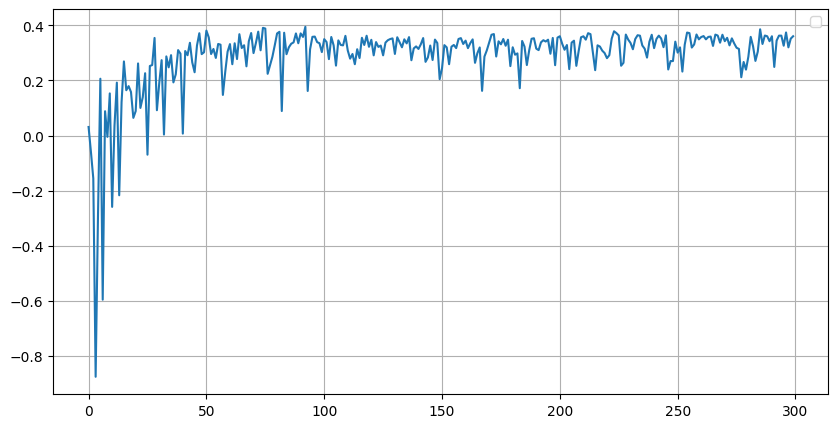

In [17]:
model = create_model(best_params['layers'], best_params['dropout'], best_params['learning_rate'])

hist = model.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test),
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    verbose=1,
    callbacks=best_params['callbacks'],
    class_weight=best_params['class_weights'],
)

In [18]:
y_pred = model.predict(X_test)

215/442 [=============>................] - ETA: 0s

442/442 [==============================] - 1s 2ms/step


In [19]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, y_pred.round()))
print(classification_report(y_test, y_pred.round()))

[[10166  3556]
 [   87   310]]
              precision    recall  f1-score   support

         0.0       0.99      0.74      0.85     13722
         1.0       0.08      0.78      0.15       397

    accuracy                           0.74     14119
   macro avg       0.54      0.76      0.50     14119
weighted avg       0.97      0.74      0.83     14119



In [20]:
import pickle
# Save model
models_dir = 'models/nn_shift_target'
os.makedirs(models_dir, exist_ok=True)
model.save(os.path.join(models_dir, 'model.h5'))
#encoder_path = os.path.join(models_dir, 'encoder.pkl')
#with open(encoder_path, 'wb') as f:
#    pickle.dump(encoder, f)

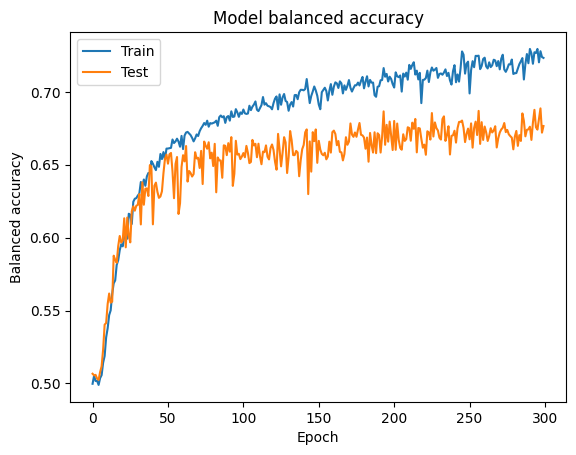

In [21]:
import matplotlib.pyplot as plt

plt.plot(hist.history['balanced_accuracy_loss'])
plt.plot(hist.history['val_balanced_accuracy_loss'])
plt.title('Model balanced accuracy')
plt.ylabel('Balanced accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(os.path.join(models_dir, 'balanced_accuracy.svg'), format='svg')
plt.show()